
#### Importing Libraries

In [485]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


![kneeding](https://media.giphy.com/media/RpckSiHL6ZaXS/giphy.gif)

# Enhancing Regression Models

Objectives, be able to use:

Pre-processing:
- handling non-numeric data
 - categorical: get_dummies/one-hot-encoder
 - binary encoder
 - ordinal: label encoder
- Scaling

Creating New:
- Interaction terms
- Polynomials


Evaluating:
- R^2 vs adjusted R^2
- comparing model performance metrics - metrics going up or down?


## Scenario: car seat sales

Description: simulated data set on sales of car seats<br>
Format: 400 observations on the following 11 variables
- Sales: unit sales at each location
- CompPrice: price charged by nearest competitor at each location
- Income: community income level
- Advertising: local advertising budget for company at each location
- Population: population size in region (in thousands)
- Price: price charged for car seat at each site
- **ShelveLoc: quality of shelving location at site (Good | Bad | Medium)**
- Age: average age of the local population
- Education: education level at each location
- **Urban: whether the store is in an urban or rural location**
- **USA: whether the store is in the US or not**

 We will attempt to predict ${\tt Sales}$ (child car seat sales) in 400 locations based on a number of predictors.

In [486]:
original_df = pd.read_csv('Carseats.csv')
df = original_df.copy()

In [487]:
!pwd

/Users/johnmaxbarry/Documents/master_cohort_folder/module_4/feature_eng


In [488]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [489]:
from sklearn.model_selection import train_test_split
X = df.drop('Sales', axis=1)
y = df['Sales']

# Train-test split, then "set aside" test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


## Numeric Data
We have already gone over the first preprocessing steps: dropping duplicates, scaling, dropping na's.  Look in the data_prep python module for the code that performs these steps in this notebook.


In [490]:
from data_prep import prepare_df, scale_numeric
X_train_num = scale_numeric(X_train)
y_train_num = y_train.loc[X_train_num.index]
X_train_num.head()



,CompPrice,Income,Advertising,Population,Price,Age,Education
157,-0.237664,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613
109,-0.619016,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686
17,1.414862,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337
347,-1.826631,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962
24,1.287744,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188


Awesome.  Our numeric data is now standard scaled, i.e. centered around zero with a standard deviation of 1.  We also removed outliers outside of 2.5 standard deviations. Let's look at our boxplot.

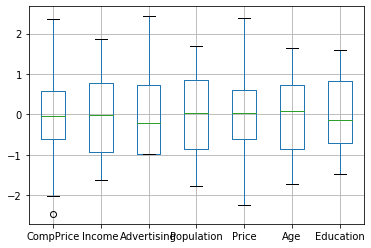

In [491]:
X_train_num.boxplot()

We import the LinearRegression module from, suprise suprise, the sklearn linear_model.  Then, we instantiate a LinearRegression object, and fit on the Training set.  **Always fit on your training set.**  

In [492]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_num, y_train_num)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [493]:
# Once we have fit our model, we can predict values.
y_hat_train = lr.predict(X_train_num)




In [494]:
# Let's look at the predictions versus the actual y_train values.
print(list(zip(y_train[:5], y_hat_train[:5])))


[(10.21, 9.729408501266827), (8.98, 7.421063041688901), (12.29, 9.182149132199134), (6.88, 5.424117767094023), (10.14, 11.525870374190514)]


In [495]:
# Let's look at the difference of the first five
errors = [y_hat - true for y_hat, true in zip(y_hat_train, y_train)]
print(errors[:5])


[-0.4805914987331743, -1.558936958311099, -3.107850867800865, -1.455882232905977, 1.3858703741905138]


Import metrics to assess our model.  We have learned R-Squared, Ajusted R-Squared, Mean Squared Error, and Root Mean Squared Error.

In [496]:
from sklearn.metrics import r2_score, mean_squared_error
print(f'r2_score {r2_score(y_train_num, y_hat_train)}')
print(f'r2_score {lr.score(X_train_num, y_train_num)}')
print('Same thing, different inputs')


r2_score 0.512698431679953
r2_score 0.512698431679953
Same thing, different inputs


We can also use statsmodels to output a more detailed summary, with adjusted-rsquared and p-values, among other things 

In [497]:

import statsmodels.formula.api as smf
feature_formula = " + ".join(X_train_num.columns)
sm_formula = 'Sales ~ ' + feature_formula
train_data = X_train_num.join(y_train_num)
results = smf.ols(sm_formula, data=train_data).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     39.38
Date:                Fri, 31 Jan 2020   Prob (F-statistic):           1.48e-37
Time:                        09:39:48   Log-Likelihood:                -550.43
No. Observations:                 270   AIC:                             1117.
Df Residuals:                     262   BIC:                             1146.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3346      0.115     63.834      0.000       7.108       7.561
CompPrice       1.3616      0.149      9.114      0.000       1.067       1.656
Income          0.1473      0.116      1.267      0.206      -0.082       0.376
Advertising     0.8344      0.125      6.689      0.000       0.589       1.080
Population      0.0342      0.121      0.283      0.777      -0.204       0.273
Price          -2.0426      0.153    -13.326      0.000      -2.344      -1.741
Age            -0.7513      0.116     -6.486      0.000      -0.979      -0.523
Education      -0.1543      0.116     -1.325      0.186      -0.384       0.075
==============================================================================
Omnibus:                        2.585   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.534
Skew:                           0.183   Prob(JB):                        0.282
Kurtosis:                       2.699   Cond. No.                         2.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 We have a very low r-squared, meaning our model has high bias.

## Categorical Variables

In [498]:
# Let's split off our categorical variables
X_train_cat = X_train.select_dtypes(include='object')
X_train_cat.head()


,ShelveLoc,Urban,US
157,Medium,No,Yes
109,Medium,No,No
17,Good,Yes,Yes
347,Good,No,No
24,Bad,Yes,Yes


We have three categorical features, ShelveLoc, Urban, and US.
How would you expect to translate these categories into input that a machines are familiar with?

# your answer here
Urban and US are binary, Yes/No, so let's handle them first.
From sklearn.preprocessing, we can import a module called LabelBinarizer


In [499]:
from sklearn.preprocessing import LabelBinarizer
# Label Binarizer uses familiar syntax.
us_lb = LabelBinarizer()
X_train_cat["US"] = us_lb.fit_transform(X_train_cat["US"])
urb_lb = LabelBinarizer()
X_train_cat["Urban"]= urb_lb.fit_transform(X_train_cat["Urban"])


Now let's deal with ShelveLoc. We have a couple of ways we could handle it. The first way we will discuss is the poorly named dummy variables.  


In [500]:
pd.get_dummies(X_train_cat['ShelveLoc'])


,Bad,Good,Medium
157,0,0,1
109,0,0,1
17,0,1,0
347,0,1,0
24,1,0,0
...,...,...,...
71,0,0,1
106,0,0,1
270,0,1,0
348,0,1,0


Great! That was easy! But what are we forgetting? The dummy variable trap.

In [501]:
pd.get_dummies(X_train_cat['ShelveLoc'], drop_first = True)


,Good,Medium
157,0,1
109,0,1
17,1,0
347,1,0
24,0,0
...,...,...
71,0,1
106,0,1
270,1,0
348,1,0


What does it mean to have dropped the "Bad" column?

We can also use One Hot Encoder. OneHotEncoder has the advantage of the .fit() method.  The encoder can then be saved and used on future data.

In [502]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
oh_features = pd.DataFrame(ohe.fit_transform(X_train[['ShelveLoc']]))
oh_features.columns = list(ohe.categories_[0])[1:]
oh_features.index = X_train.index
oh_features.head()




,Good,Medium
157,0.0,1.0
109,0.0,1.0
17,1.0,0.0
347,1.0,0.0
24,0.0,0.0


Another option would be to apply Label Encoder.  Perhaps we have prior knowledge about the relative value of Bad, Mediumm, and Good shelf locations.  Perhaps we think that Medium is twice as important as Bad, and Good is 3 times as important as Bad.  We can then do the following:

In [503]:
def bgm_encoder(element):
    if element == 'Bad':
        return 0
    elif element == 'Medium':
        return 1
    else:
        return 2

X_train['ShelveLoc'].apply(bgm_encoder)

157    1
109    1
17     2
347    2
24     0
      ..
71     1
106    1
270    2
348    2
102    1
Name: ShelveLoc, Length: 280, dtype: int64

Fitting a linear regression to the data encoded in this way treats the feature as a continuous independent variable.  If our domain knowledge is good, then such a fit could perform better than the dummy variable.  You can try out both ways and see the effect on the metrics.

Now, let's put together the our scaled numeric data and our encoded categorical data.  I'll use a function imported from our .py file. 

In [507]:
X_train_prepped, y_train_prepped= prepare_df(X_train, y_train)
X_train_prepped.shape



Before dropping duplicates and NAs across all columns (280, 10)
After dropping duplicates and NAs across all columns (280, 10)


TypeError: unhashable type: 'Int64Index'

In [506]:
y_train_prepped.shape

(270,)

In [443]:
# Now fit the preprocessed data
lr = LinearRegression()
lr.fit(X_train_prepped, y_train_prepped)
y_hat_train = lr.predict(X_train_prepped)
score_to_compare = r2_score(y_train_prepped, y_hat_train)
print(f'R-squared after prep: {r2_score(y_train_prepped, y_hat_train)}')


R-squared after prep: 0.8644163238219125


That's a much better R-squared!
Now, what are some other ways to improve it?

## Interaction Terms
An interaction term is a feature which accounts for the join affect of two other features that is non-additive.  Non-additive is the important distinction here, since our linear model is based on additive relationships of our features: i.e., add up the coefficients multiplied by a records values to get the value of the dependent variable.  But accounting for only additive affects might not account for other ways that our features can affect the target.  In our carseat example, perhaps advertising and education both contribute to increased sales while income level is below a certain point.  But imagine that for the people in the 10th percentile of education, more spending on advertising actually has a negative affect on sales.  In this case, we need an interaction term between advertising and education to account for this relationship.



In [444]:
lr = LinearRegression()
X_plus_interaction = X_train_prepped.copy()
X_plus_interaction["ed_x_adv"] = X_train_prepped["Education"] * X_train_prepped["Advertising"]
lr.fit(X_plus_interaction, y_train_prepped)
print(f"Ed times adv interaction R2 score: {lr.score(X_plus_interaction, y_train_prepped)}")
print(f"Original R2 score: {score_to_compare}")


Ed times adv interaction R2 score: 0.8644840900865273
Original R2 score: 0.8644163238219125


That made our R2 go up by a little bit.  But remember, R2 always goes up for our training set when new features are added.

We can also approach the problem of finding interaction terms iteratively.


In [445]:
from itertools import combinations
column_list = X_train_prepped.columns
interactions = list(combinations(column_list, 2))
interaction_dict = {}

for interaction in interactions:
    X_train_int = X_train_prepped.copy()
    X_train_int['int'] = X_train_int[interaction[0]]*X_train_int[interaction[1]]
    lr = LinearRegression()
    lr.fit(X_train_int, y_train_prepped)
    interaction_dict[lr.score(X_train_int, y_train_prepped)] = interaction

top_five = sorted(interaction_dict.keys(), reverse=True)[:5]
for inter in top_five:
    print(interaction_dict[inter], inter)

print(f"Original R2 score: {score_to_compare}")

('CompPrice', 'Income') 0.8697444408171716
('Income', 'Price') 0.8680830944504259
('Age', 'US') 0.8678081468246175
('Income', 'Advertising') 0.867360829140541
('US', 'Good') 0.8672953476993158
Original R2 score: 0.8644163238219125


In our model, no interaction substantially improves our R-2.


Another way to potentially improve our score is to account for non-linear relationships between target and feature.  Polynomial transformations, for example a quadratic relationship, can account for curved relationships.

Let's try adding a polynomial term to our model.



In [446]:
X_train_poly = X_train_prepped.copy()
X_train_poly['education_squared'] = X_train_poly['Education']
lr = LinearRegression()
lr.fit(X_train_poly, y_train_prepped)
print(f'R_2 with education**2 {lr.score(X_train_poly, y_train_prepped)}')
print(f"Original R2 score: {score_to_compare}")


R_2 with education**2 0.8644163238219126
Original R2 score: 0.8644163238219125


Again, little effect.
Instead of adding one polinomial at a time, we can add multiple using sklearn.

In [448]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(pf.fit_transform(X_train_prepped))
# Let's look at the shape
print(pf.get_feature_names())
print(X_train_prepped.shape)
print(X_train_poly.shape)

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x8^2', 'x8 x9', 'x8 x10', 'x9^2', 'x9 x10', 'x10^2']
(270, 11)
(270, 78)


In [449]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train_prepped)
print(lr.score(X_train_poly, y_train_prepped))
print(f"Original R2 score: {score_to_compare}")


0.8949645667557969
Original R2 score: 0.8644163238219125


That improved our R2, but it also added a lot of features. This can lead to our model being overfit.
What metric can we use to penalize for many features?
**adjusted R-squared**

In [450]:
X_train_poly.shape[0]

270

In [451]:
poly_r2 = lr.score(X_train_poly, y_train_prepped)
n = X_train_poly.shape[0]
k = X_train_poly.shape[1]
print(k)
adjusted_r2 = 1 - ((1-poly_r2)*(n-1))/(n-k-1)
print(f'Adjusted R2: {adjusted_r2}')
print(f'R2: {poly_r2}')

78
Adjusted R2: 0.8520705154832952
R2: 0.8949645667557969


Polynomials have diminishing returns!

![polynomials](https://sc.cnbcfm.com/applications/cnbc.com/resources/files/2015/12/11/emotionandincome-01_0.png)

# Validate

Even though polynomials and interactions did not have much affect on our model, we are still  fairly happy with our train r^2, so we validate on our test set. Luckily, since we have been packaging our preprocessing code in a py file, the validation is a breeze.

In [452]:
X_train, y_train = prepare_df(X_train, y_train)
X_test, y_test = prepare_df(X_test, y_test)



Before dropping duplicates and NAs across all columns (280, 10)
After dropping duplicates and NAs across all columns (280, 10)
Before dropping duplicates and NAs across all columns (120, 10)
After dropping duplicates and NAs across all columns (120, 10)


In [453]:
X_train.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,Good,Medium
157,-0.237664,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613,0,1,0.0,1.0
109,-0.619016,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686,0,0,0.0,1.0
17,1.414862,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337,1,1,1.0,0.0
347,-1.826631,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962,0,0,1.0,0.0
24,1.287744,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188,1,1,0.0,0.0


In [454]:
X_test.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,Good,Medium
209,-1.927926,-1.923401,0.519903,0.415358,-1.045455,1.427581,-1.164754,0,1,0.0,0.0
280,-0.316943,0.517225,0.377138,1.524573,1.319989,-0.180055,-1.548739,1,1,0.0,0.0
33,-0.807242,-1.285083,0.805433,0.356634,0.588852,-0.244361,0.755170,1,1,1.0,0.0
210,-0.036772,-1.172439,-0.764983,0.617626,0.373812,-0.437277,-0.012799,0,1,0.0,0.0
93,1.364082,-1.585468,-1.050513,-1.274564,-0.443342,0.077167,1.139155,1,0,0.0,1.0


In [455]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_test = lr.predict(X_test)
r2_score(y_test, y_hat_test)

0.8568448971371858

Pretty good test R-squared.
Now let's look at the coefficients.

In [460]:
coef_list = []
for feature, coef in zip(X_train.columns, lr.coef_):
    print(feature, coef)
    coef_list.append((coef, feature))

CompPrice 1.459253359261756
Income 0.3885170715787046
Advertising 0.8294864720525061
Population 0.050276127873743366
Price -2.312466487713049
Age -0.7896197142474195
Education -0.0807830281310051
Urban 0.13975913648018903
US -0.3121281331519432
Good 4.879806984434609
Medium 2.092525885100102


In [464]:
for coef in sorted(coef_list, reverse=True):
    print(coef)



(4.879806984434609, 'Good')
(2.092525885100102, 'Medium')
(1.459253359261756, 'CompPrice')
(0.8294864720525061, 'Advertising')
(0.3885170715787046, 'Income')
(0.13975913648018903, 'Urban')
(0.050276127873743366, 'Population')
(-0.0807830281310051, 'Education')
(-0.3121281331519432, 'US')
(-0.7896197142474195, 'Age')
(-2.312466487713049, 'Price')
